Node root position: (0, 0)
Node revol position: (1.5320888862379562, 1.2855752193730785)
Node -ution position: (-1.7740216663564436, -0.9234972264700675)
Node revolvere position: (3.2428934686808493, 2.3417177350797616)
Node -utionem, -utionis position: (-3.5480433327128877, -1.846994452940134)
Node re- position: (5.068148505683952, 3.2115215590641006)
Node volvere position: (5.994906135606495, 0.24718500210893596)
Node *wel- position: (7.975692415840129, 0.6231616868118979)


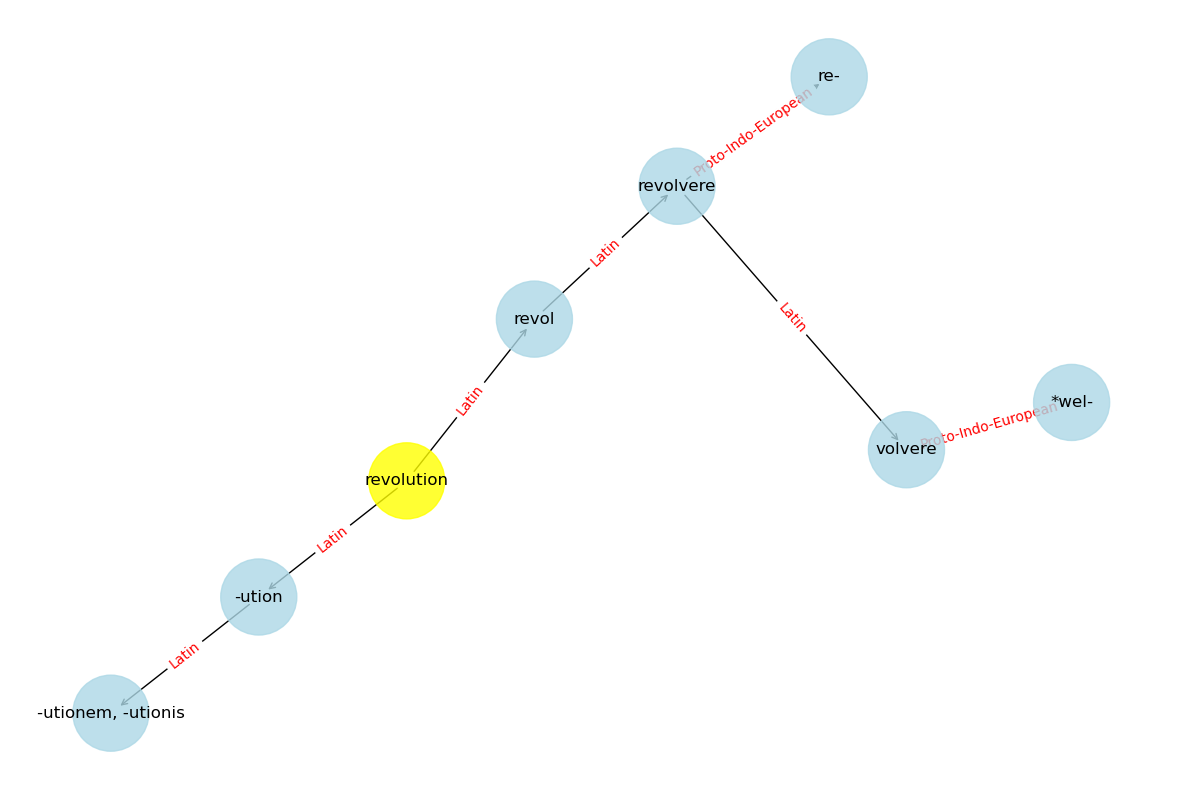

In [6]:
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math

class EtymologyGraph:
    def __init__(self, filepath):
        self.filepath = filepath
        self.G = nx.DiGraph()
        self.pos = {}
        self.load_and_prepare_data()

    def load_and_prepare_data(self):
        with open(self.filepath, "r") as fd:
            etymology_data = json.load(fd)
        self.assign_ids(etymology_data)
        self.add_to_graph(etymology_data)
        self.calculate_positions()

    def assign_ids(self, data, current_id=0):
        data['id'] = current_id
        current_id += 1
        for part in data.get('etymology', []):
            current_id = self.assign_ids(part, current_id)
        return current_id

    def add_to_graph(self, data, parent=None):
        node_id = data['id']
        node_label = data.get('part', data.get('word', ''))
        node_data = {key: data.get(key, '') for key in ['part', 'language', 'meaning', 'example_words']}
        self.G.add_node(node_id, **node_data, label=node_label)
        if parent is not None:
            self.G.add_edge(parent, node_id)
        for child in data.get('etymology', []):
            self.add_to_graph(child, node_id)

    def calculate_positions(self):
        depths = {}
        nodes_by_depth = {}
        def calculate_depths(node, depth=0):
            depths[node] = depth
            for successor in self.G.successors(node):
                calculate_depths(successor, depth + 1)

        calculate_depths(0)  # Assuming the root node has ID 0

        for node, depth in depths.items():
            nodes_by_depth.setdefault(depth, []).append(node)

        radius_increment = 2
        reserved_angle = 30  # Reserved angle for the horizontal region for all nodes
        initial_angle = 45  # Initial location adjustment

        def adjust_angle(angle, depth, index, total_siblings):
            half_reserved = reserved_angle / 2
            if 0 <= angle < 180:
                adjusted_angle = (angle - half_reserved) * ((180 - reserved_angle) / 180) + half_reserved
            elif 180 <= angle < 360:
                adjusted_angle = ((angle - 180) - half_reserved) * ((180 - reserved_angle) / 180) + 180 + half_reserved
            else:
                adjusted_angle = angle
            if depth > 1 and total_siblings > 1:
                parent_sector_angle = (360 - reserved_angle) / (total_siblings - 1)
                adjusted_angle = (parent_sector_angle * index) + (adjusted_angle if adjusted_angle < 180 else adjusted_angle - 360)
            return adjusted_angle

        for depth, nodes in nodes_by_depth.items():
            radius = depth * radius_increment
            if depth == 0:
                self.pos[0] = (0, 0)
                continue
            if depth == 1:
                angle_increment = (360 - reserved_angle) / max(len(nodes), 1)
                for i, node in enumerate(nodes):
                    angle = initial_angle + i * angle_increment
                    adjusted_angle = adjust_angle(angle, depth, i, len(nodes))
                    self.pos[node] = (radius * np.cos(np.radians(adjusted_angle)), radius * np.sin(np.radians(adjusted_angle)))
            else:
                for i, node in enumerate(nodes):
                    parent = list(self.G.predecessors(node))[0]
                    parent_pos = self.pos[parent]
                    parent_angle = np.degrees(np.arctan2(parent_pos[1], parent_pos[0]))
                    siblings = list(self.G.successors(parent))
                    index = siblings.index(node)
                    total_siblings = len(siblings)
                    adjusted_angle = adjust_angle(parent_angle, depth, index, total_siblings)
                    self.pos[node] = (radius * np.cos(np.radians(adjusted_angle)), radius * np.sin(np.radians(adjusted_angle)))

        # Printing positions for verification
        for node, position in self.pos.items():
            node_label = 'root' if node == 0 else self.G.nodes[node]['label']
            print(f"Node {node_label} position: {position}")

    def plot_graph(self):
        plt.figure(figsize=(15, 10))
        node_colors = ["lightblue" if node != 0 else "yellow" for node in self.G.nodes()]
        nx.draw_networkx_nodes(self.G, self.pos, node_size=3000, node_color=node_colors, alpha=0.8)

        # Draw edges
        nx.draw_networkx_edges(self.G, self.pos, arrowstyle="->", arrowsize=10, edge_color="black")

        # Draw node labels
        node_labels = {node: self.G.nodes[node]['label'] for node in self.G.nodes()}
        nx.draw_networkx_labels(self.G, self.pos, labels=node_labels, font_size=12)

        # Draw edge labels with language information
        edge_labels = {(source, target): f"{self.G.nodes[target]['language']}" for source, target in self.G.edges()}
        nx.draw_networkx_edge_labels(self.G, self.pos, edge_labels=edge_labels, font_color='red')

        plt.axis('off')
        plt.show()
        
# Usage example
graph = EtymologyGraph("jsons/revolution.json")
graph.plot_graph()
